In [1]:
import math
import random
import numpy as np
import gym
import cv2

In [2]:
class GameScreen:
    def __init__(self, conf):
        self.buffer = np.zeros([conf['pool_frame_size'],conf['screen_height'],conf['screen_width']],dtype=np.float32)
        
    def add(self, screen):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = screen
        
    def get(self):        
        return np.amax(np.transpose(self.buffer,(1,2,0)),axis=2)

In [3]:
class GymEnvironment():
    def __init__(self,name,conf):
        self.env = gym.make(name)            # Initialize Gym environment
        self.buffer = GameScreen(conf)
        self.screen_width = conf['screen_width']         
        self.screen_height = conf['screen_height']
        self.random_start = conf['random_start']
        self.action_repeat = conf['action_repeat']
        self.pool_frame_size = conf['pool_frame_size']
        self.display = conf['display']
        
    def new_game(self):
        self._observation = self.env.reset()
        
        for i in range(self.pool_frame_size):
            self.buffer.add(self.observation)
            
        self.render()        
        return self.screen
    
    def new_random_game(self):  # Starts a random new game doing 
        _ = self.new_game()
        for _ in xrange(random.randint(0,self.random_start-1)):
            self._observation, reward, terminal, _ = self.env.step(0)
        
        self.render()
        return self.screen, 0, terminal
        
    def execute_action(self,action,is_training=True):
        # This function execute the selected action for 'action_repeat' number of times and returns the cumulative reward
        # and final state
        cum_reward = 0
        start_lives = self.num_lives
        
        for _ in xrange(self.action_repeat):
            self._observation, reward, terminal, _ = self.env.step(action)
            cum_reward += reward
            
            if is_training and start_lives > self.num_lives:
                terminal = True
                
            if terminal:
                break
                
        self.render()
        
        return self.screen, cum_reward, terminal
    
    @property
    def screen(self):
        return self.buffer.get()
        
    @property
    def action_size(self):
        return self.env.action_space.n        # Number of available actions

    @property
    def num_lives(self):
        return self.env.ale.lives()
    
    @property
    def observation(self):     # Method to resize the screen provided by gym to the desired values
        return cv2.resize(cv2.cvtColor(self._observation,cv2.COLOR_RGB2GRAY)/255.,(self.screen_width,self.screen_height))
    
    def render(self):    # Renders the environment only if display == True
        if self.display:
            self.env.render()        

In [9]:
conf_parameters = {
    # Input size
    'screen_width': 84,
    'screen_height': 84,
    'pool_frame_size': 2,
    
    'random_start': 30,           # Maximum number of 'do nothing' actions at the start of an episode

    # Clip rewards
    'min_reward': -1.0,
    'max_reward': 1.0,

    # How many times should the same action be taken
    'action_repeat': 1,    # Gym Breakout-v0 is already repeating the action sampling k from {2,3,4}
    
    # Whether or not to render the environment 
    'display': True,
}

env = GymEnvironment('Breakout-v0',conf_parameters)

#s, r, terminal = env.new_random_game()
s = env.new_game()
cum_reward = 0
terminal = False

while not terminal:
    action = raw_input()
    action = int(action)
    if action == 6:
        break
    s,r,terminal = env.execute_action(action)
    cum_reward += r
    
print(cum_reward)
env.env.render(close=True)

[2016-12-20 16:31:27,372] Making new env: Breakout-v0


6
0


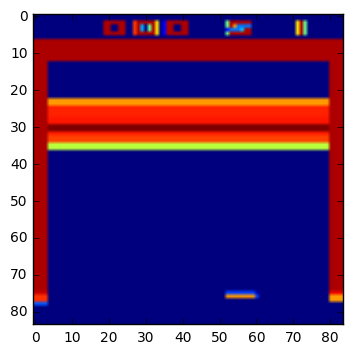

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

imgplot = plt.imshow(s)
